Financial Analysis with Agentic AI Project

Final Work Split:  
Denis -> Part 0, 3, 4, 5, 6, half of 7, Github setup  
Mustafa -> Part 1, 2, half of 7, 8, Final Summary  

Project Architecture:  
This section covers the flow and structure of the project code. When the code is first run, a planner/executor agent is used. The LLM based planner produces an ordered plan of steps (fetch_prices/financials/macro/news -> summarize -> evaluate_and_improve -> visualize -> save_memory), and the executor carries out that plan. This starts with calling the various data tools (AlphaVantage/FRED/NewsAPI/Stooq) to build clean dataframes. Then, specialist helpers help condense each stream (earnings, macro, news) into structured summaries. Following that, two synthesis paths are used to generate briefs. One focuses on a rule based approach, and the other on an LLM focus. Then, a critic function scores coverage, evidence, and actionability, and either improves the brief or asks the LLM to include an explicit action. After that, visuals are produced from the computed metrics (MAs, RSI, vol, drawdown, monthly returns). Then a small memory stores the run's insights so a second pass can re-plan with fresh context. This results in an agentic loop system: plan -> act with tools -> summarize -> critique -> improve -> remember -> ready to iterate again. Finally, the system can be set to loop at any frequency the user wishes, producing the same outputs with feedback from the past to further optimize the plan and results achieved.

Part 0 (Setup):

In [19]:
# Necessary libraries
import os, json, time, random, pathlib, datetime as dt, math, warnings, re
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Additional libraries
try:
    import yfinance as yf
except Exception:
    yf = None

try:
    from pandas_datareader import data as pdr
except Exception:
    pdr = None

try:
    from fredapi import Fred
except Exception:
    Fred = None

# Loads API Keys
load_dotenv()

# Suppress warnings
warnings.filterwarnings("ignore")

# API keys, LLM model & repo Link
alphavantage_key = os.getenv("ALPHAVANTAGE_KEY", "")
fredapi_key = os.getenv("FREDAPI_KEY", "")
newsapi_key = os.getenv("NEWSAPI_KEY", "")
openai_key = os.getenv("OPENAI_API_KEY", "").strip()
llm_model = os.getenv("LLM_MODEL", "gpt-4").strip()
repo = "https://github.com/DMulabegovic/Financial-Analysis-with-Agentic-AI.git"

# Default plot configurations
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Reproducibility 
np.random.seed(42)
random.seed(42)

# Ticker choice
ticker = 'AAPL'

# Paths/Memory
root = pathlib.Path('.').resolve()
memory_directory = root / "memory"
memory_directory.mkdir(exist_ok=True)

# Track where data comes from
source_tracker = {"prices": None, "financials": None, "macro": None, "news": None, "llm": bool(openai_key)}

# Get current time
def current_time(): 
    return dt.datetime.utcnow().isoformat()+"Z"

# Get counts of data present per source
def source_counter(name, data_count):
    print(f"Source {name}: {data_count} entries")

# Plan notice for user
print("Plan: ")
print("Get prices, financials, news and macro. Then synthesize, evaluate, improve and save to memory.\n")

# Debug check 
print(f"\nCurrent Settings: \n")
print(f"Ticker: {ticker}\n")
print(f"Alpha Vantage: {'Present' if alphavantage_key else 'Missing'}\n")
print(f"Fred API: {'Present' if fredapi_key else 'Missing'}\n")
print(f"News API: {'Present' if newsapi_key else 'Missing'}\n")
print(f"LLM: {'Present' if openai_key else 'Missing'}\n")

Plan: 
Get prices, financials, news and macro. Then synthesize, evaluate, improve and save to memory.


Current Settings: 

Ticker: AAPL

Alpha Vantage: Present

Fred API: Present

News API: Present

LLM: Present



Part 1 (Memory & LLM Wrapper):

In [20]:
# These functions enable the agent to store, retrieve, and interact with its
# memory, allowing it to keep track of insights and decisions for each stock ticker.
# The implementation uses JSONL (JSON Lines) files, which store one JSON object per line.
def write_memory(ticker: str, entry: dict, max_keep: int = 20) -> None: 
    """
    Stores a new memory entry for a given stock ticker in a JSONL file.

    Args:
        ticker (str): The stock ticker (e.g., "AAPL").
        entry (dict): The data to be stored (insights, next actions, etc.).
        max_keep (int): Maximum number of memory entries to retain (default = 20).
    """
    # Construct file path using the ticker name
    file_path = memory_directory / f"{ticker}.jsonl"
    existing_records = []
    
    # Load any existing memory records for this ticker
    if file_path.exists():
        with open(file_path, "r", encoding="utf-8") as f:
            existing_records = [json.loads(line) for line in f if line.strip()]
    
    # Append the new entry to the list of records
    existing_records.append(entry)

    # Initialize sets to detect duplicates
    seen_signatures, deduped_records = set(), []

    # Reverse iterate through records to preserve recent ones first
    for record in reversed (existing_records):
        # Each record’s signature is based on its insights and next actions
        signature = (tuple(record.get("insights", [])), tuple(record.get("todo_next", [])))
        
        # Skip duplicates already seen
        if signature in seen_signatures:
            continue
        seen_signatures.add(signature)
        deduped_records.append(record)
    
    # Reverse back to chronological order and limit number of stored memories
    deduped_records = list(reversed(deduped_records))[-max_keep:]
    
    # Overwrite the file with the deduplicated memory records
    with open(file_path, "w", encoding="utf-8") as f:
        for record in deduped_records:
            f.write(json.dumps(record) + "\n")

def load_memory(ticker: str) -> list:
    """
    Loads all saved memory entries for a given ticker.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        list: A list of JSON decoded memory records.
    """
    file_path = memory_directory / f"{ticker}.jsonl"
    
    # Return an empty list if no memory file exists
    if not file_path.exists():
        return []
    
    # Load and return each JSON line as a dictionary
    with open(file_path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]
    
def openai_chat(chat_messages, model: Optional[str] = None, max_tokens: int = 300, temperature: float = 0.2) -> Optional[str]:
    """
    Sends a list of chat messages to the OpenAI API and retrieves the response.

    Args:
        chat_messages (list): The messages forming the chat history (role & content).
        model (str, optional): The LLM model to use (default = llm_model).
        max_tokens (int): Max tokens to generate.
        temperature (float): Creativity level of the response (lower = more focused).

    Returns:
        str | None: The text response from the model, or None if an error occurs.
    """
    # Check for missing API key
    if not openai_key:
        print("[LLM] NO OPENAI_API_KEY set, skipping LLM.")
        return None

    selected_model = model or llm_model
    print("[LLM] using model:", selected_model)
    
    try:
        # Send request to OpenAI's Chat Completion API
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers={"Authorization": f"Bearer {openai_key}", "Content-Type": "application/json"},
            json={"model": selected_model, "messages": chat_messages, "temperature": float(temperature), "max_tokens": int(max_tokens)},
            timeout=30,
        )

        # Check if request was successful
        response.raise_for_status() 
        # Extract the assistant's message from API response
        return response.json()["choices"][0]["message"]["content"]
    
    # Handle specific HTTP errors
    except requests.HTTPError as http_error:
        try:
            print("[LLM] status:", response.status_code, "| body:", response.text[:300])
        except Exception:
            pass
        print("[LLM] HTTP error:", http_error)
        return None
    
    # Handle any other unexpected errors
    except Exception as error:
        print("[LLM] General error:", error)
        return None

Part 1 Summary:
In Part 1, we designed the agent’s memory system. The write_memory() and load_memory() functions handle saving and retrieving context for each ticker symbol, ensuring duplicate insights are removed and only recent records are kept. The openai_chat() function connects the agent to the OpenAI API to generate insights. Together, these establish the foundation for contextual learning and interaction.

Part 2 (Data Fetching Tools):

In [21]:
# This section defines all functions used to fetch external data for analysis.
# The pipeline relies on multiple APIs and data sources to gather:
#   • Stock price history (Yahoo Finance, Alpha Vantage, Stooq)
#   • Company financials (revenue & margins from Alpha Vantage)
#   • Macroeconomic indicators (Federal Reserve FRED)
#   • Recent news articles (NewsAPI)
#
# Each function:
#   - Has its own error handling to avoid breaking the pipeline.
#   - Logs its data source via source_tracker and source_counter.
#   - Returns standardized outputs (DataFrames or lists) for later processing.
# -------------------------------
def prices_yf(ticker: str, period: str = "1y", interval: str = "1d") -> Optional[pd.DataFrame]:
    """
    Fetches historical adjusted closing prices from Yahoo Finance (yfinance library).
    Falls back automatically to other APIs if unavailable.
    """
    if yf is None:
        return None

    # Attempt the request up to 3 times to handle temporary issues or rate limits
    for attempt_index in range(3):
        try:
            # Download price data from Yahoo Finance
            yf_dataframe = yf.download(
                ticker,
                period=period,
                interval=interval,
                progress=False,
                threads=False,
                auto_adjust=False,
            )

            # Validate that returned data is not empty and contains 'Adj Close'
            if isinstance(yf_dataframe, pd.DataFrame) and "Adj Close" in yf_dataframe.columns and not yf_dataframe["Adj Close"].dropna().empty:
                source_tracker["prices"] = "yfinance"
                source_counter("prices[yfinance]", f"rows={len(yf_dataframe)}")
                return yf_dataframe[["Adj Close"]].dropna()
        
        except Exception as error:
            # Handle rate limit errors with exponential backoff (retry delay doubles each attempt)
            if "Too Many Requests" in str(error) or "RateLimit" in str(error):
                time.sleep(5 * (2 ** attempt_index))
            else:
                # Break early for other errors
                break
    # Return None if all attempts fail
    return None


def prices_alpha_vantage(ticker: str) -> Optional[pd.DataFrame]:
    """
    Fetches adjusted closing prices from the Alpha Vantage API.
    Acts as a secondary source if yfinance fails.
    """
    if not alphavantage_key:
        return None
    
    try:
        # Configure API endpoint and parameters
        url = "https://www.alphavantage.co/query"
        params = {
            "function": "TIME_SERIES_DAILY_ADJUSTED",
            "symbol": ticker,
            "outputsize": "compact",
            "apikey": alphavantage_key,
        }
        
        # Send request and check for errors
        response = requests.get(url, params=params, timeout=20)
        response.raise_for_status()

        # Parse the daily time series data
        time_series_json = response.json().get("Time Series (Daily)", {}) or {}
        
        if not time_series_json:
            return None
        
        # Convert to DataFrame and select only the adjusted close column
        av_dataframe = (
            pd.DataFrame(time_series_json).T
            .rename(columns={"5. adjusted close": "Adj Close"})
            [["Adj Close"]]
            .astype(float)
        )
        
        # Sort chronologically and standardize index
        av_dataframe.index = pd.to_datetime(av_dataframe.index)
        av_dataframe = av_dataframe.sort_index()
        
        source_tracker["prices"] = "alphavantage"
        source_counter("prices[alphavantage]", f"rows={len(av_dataframe)}")
        
        return av_dataframe
    
    # Handle errors
    except Exception as error:
        print("[AV prices] error:", error)
        
        return None


def prices_stooq(ticker: str) -> Optional[pd.DataFrame]:
    """
    Fetches historical stock prices from Stooq.
    Serves as a final fallback when both yfinance and Alpha Vantage fail.
    """
    if pdr is None:
        return None
    
    try:
        # Query Stooq data via pandas_datareader
        stooq_dataframe = pdr.DataReader(ticker, "stooq").sort_index()
        
        # Check for valid 'Close' column and rename to match other sources
        if "Close" in stooq_dataframe.columns and not stooq_dataframe["Close"].dropna().empty:
            out = stooq_dataframe[["Close"]].rename(columns={"Close": "Adj Close"})
            
            source_tracker["prices"] = "stooq"
            source_counter("prices[stooq]", f"rows={len(out)}")
            
            return out
    
    # Handle errors
    except Exception as error:
        print("[STOOQ] error:", error)
        
        return None


def get_prices(ticker: str, period: str = "1y", interval: str = "1d") -> pd.DataFrame:
    """
    Wrapper function that tries multiple price sources sequentially.
    Returns the first successfully retrieved DataFrame.
    """
    for fetcher in (prices_yf, prices_alpha_vantage, prices_stooq):
        # yfinance requires extra parameters; others do not
        price_df = fetcher(ticker) if fetcher is not prices_yf else fetcher(ticker, period=period, interval=interval)
        
        if isinstance(price_df, pd.DataFrame) and not price_df.empty:
            return price_df

    # Log the failure if no source provided valid data    
    source_counter("get_prices", "no live source available — returned empty DataFrame")

    return pd.DataFrame(columns=["Adj Close"])


def get_financials(ticker: str) -> pd.DataFrame:
    """
    Retrieves company-level financial metrics from Alpha Vantage.
    Specifically extracts revenue (in billions) and trailing-twelve-month gross margin.
    """
    if not alphavantage_key:
        source_counter("financials", "Alpha Vantage key missing — returned empty DataFrame")
        return pd.DataFrame(columns=["revenue_bil", "ttm_margin"])
    
    # API request setup
    try:
        url = "https://www.alphavantage.co/query"
        params = {"function": "INCOME_STATEMENT", "symbol": ticker, "apikey": alphavantage_key}
        
        response = requests.get(url, params=params, timeout=20)
        response.raise_for_status()

        annual_reports = response.json().get("annualReports", [])[:4]

        if not annual_reports:
            source_counter("financials[alphavantage]", "no annualReports")
            return pd.DataFrame(columns=["revenue_bil", "ttm_margin"])
        
        # Parse annual reports for revenue and gross profit
        rows = []
        for report in annual_reports:
            total_revenue = float(report.get("totalRevenue", "nan"))
            gross_profit = float(report.get("grossProfit", "nan")) if report.get("grossProfit") else np.nan
            
            rows.append({
                "date": report["fiscalDateEnding"],
                "revenue_bil": (total_revenue / 1e9 if not math.isnan(total_revenue) else np.nan),
                "gp": gross_profit,
                "rev_raw": (total_revenue if not math.isnan(total_revenue) else np.nan),
            })

        financials_dataframe = pd.DataFrame(rows).sort_values("date")

        # Calculate trailing-twelve-month (TTM) margin using a rolling mean
        with np.errstate(divide="ignore", invalid="ignore"):
            gross_margin = financials_dataframe["gp"] / financials_dataframe["rev_raw"]

        financials_dataframe["ttm_margin"] = pd.Series(gross_margin).rolling(4, min_periods=1).mean()
        financials_dataframe = financials_dataframe.set_index(pd.to_datetime(financials_dataframe["date"]))[["revenue_bil", "ttm_margin"]]

        source_tracker["financials"] = "alphavantage"
        source_counter("financials[alphavantage]", f"rows={len(financials_dataframe)}")
        
        return financials_dataframe
    
    # Handle errors
    except Exception as error:
        print("[AV financials] error:", error)
        return pd.DataFrame(columns=["revenue_bil", "ttm_margin"])


def get_macro(series_id: str = "CPIAUCSL", start: str = "2019-01-01") -> pd.DataFrame:
    """
    Downloads macroeconomic indicators (e.g., inflation, GDP, interest rate)
    from the Federal Reserve Economic Database (FRED).
    """
    if Fred is None or not fredapi_key:
        source_counter("macro", "FRED key/module missing — returned empty DataFrame")
        return pd.DataFrame(columns=[series_id])
    
    try:
        # Initialize FRED client and fetch requested series
        fred = Fred(api_key=fredapi_key)
        series_data = fred.get_series(series_id, observation_start=start)
        macro_df = series_data.to_frame(name=series_id)

        source_tracker["macro"] = "fred"
        source_counter("macro[fred]", f"rows={len(macro_df)}")

        return macro_df
    
    # Handle errors
    except Exception as error:
        print("[FRED] error:", error)
        return pd.DataFrame(columns=[series_id])


def news_newsapi(ticker: str, n: int = 8) -> List[Dict]:
    """
    Fetches recent company-related articles from NewsAPI.
    Normalizes each record to include title, content, date, and source name.
    """
    if not newsapi_key:
        return []
    
    url = "https://newsapi.org/v2/everything"
    from_date = (datetime.utcnow() - timedelta(days=14)).strftime("%Y-%m-%d")
    
    # Request news articles for the given ticker
    response = requests.get(
        url,
        params={
            "q": ticker,
            "from": from_date,
            "sortBy": "publishedAt",
            "language": "en",
            "pageSize": min(max(n, 5), 50),
            "apiKey": newsapi_key,
        },
        timeout=20,
    )

    response.raise_for_status()
    articles_json = response.json().get("articles", [])

    normalized_articles = []
    
    # Normalize response for consistent downstream use
    for article in articles_json[:n]:
        normalized_articles.append({
            "title": article.get("title") or "",
            "content": ((article.get("description") or "") + " " + (article.get("content") or "")).strip(),
            "published": article.get("publishedAt") or "",
            "source": (article.get("source") or {}).get("name", "newsapi"),
        })

    return normalized_articles


def get_news(ticker: str, n: int = 8) -> List[Dict]:
    """
    Wrapper for NewsAPI that handles missing API keys and logs metadata.
    Returns a list of cleaned article dictionaries.
    """
    if not newsapi_key:
        source_counter("news", "NEWSAPI key missing — returned empty list")
        return []
    
    try:
        news_items = news_newsapi(ticker, n=n)

        source_tracker["news"] = "newsapi"
        source_counter("news[newsapi]", f"articles={len(news_items)}")

        return news_items
    
    # Handle errors
    except Exception as error:
        print("[NEWSAPI] error:", error)
        return []

Part 2 Summary:  
This section establishes the data ingestion layer of the analysis pipeline responsible for gathering all raw inputs used in subsequent analytics and modeling. It integrates multiple APIs and open data sources to ensure resilience, accuracy, and redundancy when fetching financial and economic information.  
  
Core Functions:  
  
* get_prices() – Retrieves historical stock prices from:  
  
    Primary: Yahoo Finance (yfinance)  
    Secondary: Alpha Vantage API  
    Fallback: Stooq (via pandas_datareader)  
    Includes retry logic and exponential backoff to handle rate limits.  
  
* get_financials() – Extracts company level fundamentals such as annual revenue (in billions) and trailing twelve month gross margins from Alpha Vantage.  
  
* get_macro() – Pulls macroeconomic indicators (e.g., inflation, GDP, rates) from the Federal Reserve Economic Database (FRED) for broader market context.  
  
* get_news() – Uses NewsAPI to collect recent company specific news articles, cleaning and normalizing the text for later sentiment or keyword analysis.  
  
Built-In Safegaurds:  
* Automatic source fallback when a data provider fails or rate limits occur.  
* Source logging via source_tracker and source_counter for transparency.  
* Uniform output structures (DataFrame or list[dict]) for pipeline compatibility.  
* Comprehensive error handling to prevent data retrieval issues from halting execution.  
  
Output Summary:  
* By the end of this part, the notebook produces:  
* Validated price history, financial metrics, and macro-economic series  
* Cleaned and timestamped news articles ready for NLP processing  
* Internal logs identifying which data sources were successfully used  

Part 3 (Prompt Chaining & Routing):

In [22]:
# This section provides simple text utilities:
# 1) sentiment_analysis: keyword based "bull/bear/neutral"
# 2) route_doc_rule_based: rule driven router (earnings/macro/news)
# 3) route_doc_llm: optional LLM router with rule based feedback (more expensive, requires more openAI credit to run)

# Keyword lists used by the simple sentiment classifier
positive = ['beat', 'record', 'growth', 'surge', 'strong']
negative = ['miss', 'decline', 'weak', 'cut', 'lawsuit']

# This first function aims to classify a text snippet into "bull", "bear" or "neutral" using simple keywords. This is
# done through conditional checks to see if certain keywords are present. 
def sentiment_analysis(text: str) -> str:
    if not isinstance(text,str) or not text.strip(): return 'neutral'

    text_lower = text.lower()

    if any(keyword in text_lower for keyword in positive): 
        return 'bull'
    
    if any(keyword in text_lower for keyword in negative): 
        return 'bear'
    
    return 'neutral'

# This function routes a news item to either "earnings", "macro" or "news" using keywords. Again this
# is done through conditional checks for specific keywords in the combined text provided. A priority 
# system is also in place earnings > macro > news.
def route_doc_rule_based(title: str, content: str) -> Tuple[str,str]:
    combined_text = f"{title} {content}".lower()

    earnings_terms = ["eps", "guidance", "revenue", "quarter", "q1", "q2", "q3", "q4", "beat", "miss", "outlook", "gross margin"]
    macro_terms = ["inflation", "cpi", "ppi", "rates", "fed", "pmi", "jobs", "payrolls", "unemployment", "gdp", "ism"]


    if any(keyword in combined_text for keyword in earnings_terms): 
        return ('earnings','matched: earnings keyword')
    
    if any(keyword in combined_text for keyword in macro_terms): 
        return ('macro','matched: macro keyword')
    
    return ('news', 'fallback: general news')

# This function uses an LLM instead to do the routing work. There is also a fallback setup so if it fails,
# the reliable rule based function is called instead. This method costs more money to run since you end up
# using the OpenAI model more throughout each run. For the project's purpose this isn't necessary but it 
# does work and is here for optional use and comparisons. 
def route_doc_llm(title: str, content: str) -> Tuple[str,str]:
    if not openai_key:
        return route_doc_rule_based(title, content)
    
    prompt = ("Route to one of: earnings, macro, news. Return JSON with fields route and reason.\n"
              f"TITLE: {title}\nCONTENT: {content}")
    
    out = openai_chat([{"role": "user", "content": prompt}], max_tokens=160, temperature=0.0)

    if not out:
        return route_doc_rule_based(title, content)
    
    try:
        json_match = re.search(r"{.*}", out, flags=re.S)
        if json_match:
            parsed_json = json.loads(json_match.group(0))
            route_label = parsed_json.get("route", "news")
            if route_label not in {"earnings", "macro", "news"}: 
                route_label = "news"
            return (route_label, parsed_json.get("reason", "llm"))
    except Exception:
        pass
    
    return route_doc_rule_based(title, content)

Part 3 Summary:  
  
Core Functions:  
* sentiment_analysis(text) – A simple, keyword based classifier that tags text as “bull”, “bear”, or “neutral” . It's transparent and deterministic, perfect for building sentiment charts.  
* route_doc_rule_based(title, content) - Routes each article to earnings, macro, or news using clear keyword lists and a fixed priority (earnings > macro > news). Returns both the route and a short reason.  
* route_doc_llm(title, content) - Uses the LLM to propose a route and reason (as JSON). If the key is missing, the response is malformed, or the route is invalid, it falls back to the rule-based router. This method is great for comparison with the original rule based option.  
  
Built In Safeguards:   
The LLM routing function can fall back to the simple rule based version should it face any errors.  
  
Output Summary:   
Once these functions are used, a few things are expected. First the classification of "bull", "bear" and "neutral" should be done and returned. Second the routing classification of "earnings", "macro" and "news" is done and returned regardless of it being the rule based or LLM approach.

Part 4 (Specialists):

In [23]:
# This section contains helpers that convert raw dataframes into small structured artifacts that
# the synthesizer can cite. Each returns a tiny dictionary with the necessary data for the brief 
# and evaluator. 

# This function summarizes the basic fundamentals and related headlines. It takes in the financial 
# dataframe and news dataframe. Then It returns the revenue trend ("up", "down", "unknown") based on
# the sign of quarterly change in revenue bill and it also returns the earnings headlines.
def summarize_earnings(finance_data: pd.DataFrame, routed_data: pd.DataFrame) -> Dict:
    if finance_data is None or finance_data.empty:
        return {'revenue_trend': 'unknown', 'earnings_headlines': []}
    
    trend = 'up' if finance_data['revenue_bil'].diff().mean() > 0 else 'down'
    headlines = routed_data.loc[routed_data['route'] == 'earnings', 'title'].tolist() if isinstance(routed_data, pd.DataFrame) else []
    
    return {'revenue_trend': trend, 'earnings_headlines': headlines}

# This function summarizes the macro backdrop over the last 12 months. It takes in the macro 
# dataframe and series id for FRED. Then It returns the macro trend ("rising", "falling", "unknown") 
# based on the calculated mean of month over month differences over the 12 months and it also returns 
# the number of months examined.
def summarize_macro(macro_data: pd.DataFrame, series_id="CPIAUCSL") -> Dict:
    if macro_data is None or macro_data.empty:
        return {'macro_trend': 'unknown', 'tail_months': 12}
    
    macro_series = macro_data[series_id].dropna()
    
    if len(macro_series) < 13:
        return {'macro_trend': 'unknown', 'tail_months': min(12, len(macro_series))}
    
    avg_monthly_change = macro_series.iloc[-12:].diff().mean()

    return {'macro_trend': 'rising' if avg_monthly_change > 0 else 'falling', 'tail_months': 12}

# This function summarizes sentiment counts. It takes in the news dataframe with a sentiment column from 
# part 3. Then It returns the counts of each sentiment type ("bull", "bear", "neutral") and the amount of
# articles considered. 
def summarize_news(news_data: pd.DataFrame) -> Dict:
    if news_data is None or news_data.empty:
        return {'counts': {'bull': 0, 'bear': 0, 'neutral': 0}, 'n': 0}
    
    sentiment_counts = news_data['sentiment'].value_counts().to_dict()
    for i in ['bull', 'bear', 'neutral']:
        sentiment_counts.setdefault(i,0)
    
    return {'counts': sentiment_counts, 'n': int(news_data.shape[0])}

Part 4 Summary:  
  
Core Functions:  
* summarize_earnings(finance_data, routed_data) - Detects whether revenue is trending up or down using the average change in revenue_bil, and collects titles of articles routed to earnings. This gives the brief both a fundamentals signal and relevant headlines.  
* summarize_macro(macro_data, series_id="CPIAUCSL") — Labels the macro backdrop as rising or falling over the last 12 months by averaging month over month changes. Returns the label and the tail window examined.  
* summarize_news(news_data) — Counts bull/bear/neutral items (with defaults if a class is missing) and returns the total number of articles. This feeds the sentiment bar chart and the brief's sentiment sentence.  
  
Output Summary:  
Here it is quite clear what is returned per function. The first returns the revenue trend and relevant earnings title. Then the second returns the macro trend and number of months examined. Finally, the third returns the counts of each sentiment type and the amount of articles considered.

Part 5 (Expanded Market Metrics):

In [24]:
# This function computes the common price derived indicators that the visuals and brief rely on.
# This includes the returns, moving averages, RSI(14), annualized volatility, cumulative return 
# drawdown and a simple rolling Sharpe ratio.

# This function carries out all the calculations necessary for the indicators mentioned above. It 
# takes in the prices dataframe and returns a dataframe with the added indicators.
def calculate_metrics(prices: pd.DataFrame) -> pd.DataFrame:
    if prices is None or prices.empty: return prices

    price_metrics = prices.copy()
    price_metrics['ret'] = price_metrics['Adj Close'].pct_change()

    price_metrics['ma20'] = price_metrics['Adj Close'].rolling(20).mean()
    price_metrics['ma50'] = price_metrics['Adj Close'].rolling(50).mean()
    price_metrics['ma200'] = price_metrics['Adj Close'].rolling(200).mean()

    price_change = price_metrics['Adj Close'].diff()
    gain = price_change.clip(lower=0)
    loss = (-price_change).clip(lower=0)
    avg_gain_14days = gain.rolling(14, min_periods=14).mean()
    avg_loss_14days = loss.rolling(14, min_periods=14).mean()
    relative_strength = avg_gain_14days / (avg_loss_14days.replace(0, np.nan))

    price_metrics['rsi14'] = 100 - (100 / (1 + relative_strength))
    price_metrics['vol20_ann'] = price_metrics['ret'].rolling(20).std() * np.sqrt(252) * 100.0
    price_metrics['cumret'] = (1 + price_metrics['ret'].fillna(0)).cumprod() - 1

    running_max_price = price_metrics['Adj Close'].cummax()

    price_metrics['drawdown'] = price_metrics['Adj Close'] / running_max_price - 1.0
    price_metrics['sharpe20'] = (price_metrics['ret'].rolling(20).mean() / price_metrics['ret'].rolling(20).std()) * np.sqrt(252)

    return price_metrics

Part 5 Summary:  
calculate_metrics(prices) — Adds core technical indicators to the price series:  
* ret: daily returns, ma20/50/200 moving averages for trend context.    
* rsi14: momentum via 14 day RSI (safe against divide by zero).    
* vol20_ann: 20 day rolling volatility (annualized).  
* cumret: cumulative return from the series start.    
* drawdown: % below the running peak.    
* sharpe20: simple 20-day rolling Sharpe.  
    
These feed our visuals and let the brief's "Action:" line reference concrete thresholds.  

Part 6 (Synthesis, Critic, Optimizer):

In [25]:
# This section has two brief synthesizer types, one being rule based and one being an LLM approach. 
# Then a critic scores the brief and a simple improver function patches common gaps. 

# This function aims to make a brief deterministically from structured artefacts. It takes in the 
# ticker, earnings data (revenue trend & earnings titles), news data (sentiment counts and number
# of articles considered) and the macro data (macro trend and the number of months analyzed). The
# function then returns a human readable brief based on the data available and a short takeaway.
def rule_based_synthesis(ticker: str, earnings: Dict, news: Dict, macro: Dict) -> str:
    bullish_count = news['counts'].get('bull', 0)
    bearish_count = news['counts'].get('bear', 0)
    neutral_count = news['counts'].get('neutral', 0)

    brief = (
        f"Ticker: {ticker}\n\n"
        f"Earnings: revenue trend appears {earnings['revenue_trend']}. "
        f"Key earnings headlines: {', '.join(earnings['earnings_headlines']) or 'none'}.\n"
        f"News sentiment (articles analyzed = {news['n']}): bullish = {bullish_count}, bear = {bearish_count}, neutral = {neutral_count}.\n"
        f"Macro context: the series of choice is {macro['macro_trend']} "
        f"over the last {macro['tail_months']} months.\n\n"
        f"Takeaway: Assess how the {macro['macro_trend']} macro environment may influence "
        f"the {earnings['revenue_trend']} trajectory in company revenues."
    )

    return brief

# This function here generates a brief using an LLM and has a built in fallback to the rule based function
# should the LLM fail for whatever reason. This takes in all the arguments the rule based synthesizer takes
# in, but also has one more, include_action, which asks the LLM to add a single "Action:" line if set to True.
def llm_synthesis(ticker: str, earnings: Dict, news: Dict, macro: Dict, include_action: bool=False) -> str:
    if not openai_key:
        return rule_based_synthesis(ticker, earnings, news, macro)
    
    action_check = "Include one line starting with 'Action:'." if include_action else "Do Not include an action line"

    prompt = (
        f"Write a concise analyst brief for {ticker} (<=160 words). {action_check}\n"
        f"Earnings: {earnings}\nNews: {news}\nMacro: {macro}"
    )
    
    out = openai_chat([{"role":"user","content":prompt}], max_tokens=220, temperature=0.2)

    return out or rule_based_synthesis(ticker, earnings, news, macro)

# This short function helps us check if an "Action:" line has a clear, specific trading instruction. It looks
# for numbers, percentages, moving averages or related trading terms. It takes in the brief and returns a 
# boolean value for the check.
def specific_action_check(brief: str) -> bool:
    if "action:" not in brief.lower():
        return False
    return bool(re.search(r"(\d+%|\d+\.?\d*|MA\s*\d|moving\s*average|stop|target|above|below)", brief, flags=re.I))

# This function then scores a brief on simple criteria that is easily traceable for the user. The criteria consists
# of a 5 point system. One point is awarded for coverage (earnings, macro and news present in artifacts). One is 
# awarded for evidence (at least 3 news articles analyzed). Then a point is given based on actionability (action line
# present and specific). Another point is awarded for factuality (if brief is supported by data retrieved). Finally,
# the last point is awarded for recency (based on data retrieved). This function takes in the brief and artifacts (
# earnings, news, macro) and returns the component scores + total + improvement comments (based on if evidence or 
# actionability lacks).
def critic(brief: str, artifacts: Dict) -> Dict:
    data_coverage_score = int(all(i in artifacts for i in ("earnings", "news", "macro")))
    evidence_score = int(artifacts["news"]["n"] >= 3)
    actionability_score = int(specific_action_check(brief))
    factuality_score = 1
    recency_score = 1
    total_score = data_coverage_score + evidence_score + actionability_score + factuality_score + recency_score

    improvement_comments = []
    if not evidence_score: improvement_comments.append("Add 3+ articles for evidence.")
    if actionability_score == 0: improvement_comments.append("Add a specific 'Action:' (threshold/MA/target).")

    return {
        "coverage": data_coverage_score,
        "evidence": evidence_score,
        "actionability": actionability_score,
        "factuality": factuality_score,
        "recency": recency_score,
        "total": total_score,
        "comments": improvement_comments
    }

# This final function aims to add the targeted edits to the brief based on critic feedback. If actionability is 0
# add an "Action:" line, if evidence is 0 add a reminder to include >= 3 balanced articles and if nothing needs 
# fixing add a default risk management action. This function takes in the brief and critic output. It returns the 
# improved brief (brief and edit instruction).
def brief_improver(brief: str, evaluation: Dict) -> str:
    revised_brief_lines = [brief, ""]

    if evaluation.get("actionability",0) == 0:
        revised_brief_lines.append("Action: If earnings day gap is > 3%, open a starter position; otherwise wait for a 20/50-day moving-average bullish cross with volume > 1.5x.")
    
    if evaluation.get("evidence",1) == 0:
        revised_brief_lines.append("Evidence: Add at least 3 balanced articles (bull, bear, neutral).")
    
    if len(revised_brief_lines) == 2:
        revised_brief_lines.append("Action: Set stop 2x ATR below entry; re-check after the call transcript.")
    
    return "\n".join(revised_brief_lines).strip()

Part 6 Summary:  
  
Core Functions:  
* rule_based_synthesis(ticker, earnings, news, macro) — Deterministic brief from artifacts (earnings/news/macro) providing a simple baseline brief for comparison.  
* llm_synthesis(ticker, earnings, news, macro, include_action) — LLM generated brief with optional “Action:” line. This falls back to rule based if LLM is unavailable.  
* specific_action_check(brief) — Heuristic checker for actionable content (numbers, %, MA references, trading terms).  
* critic(brief, artifacts) — Scores coverage, evidence, actionability, factuality, recency; returns component scores, total score, and concise comments.  
* brief_improver(brief, evaluation) — Applies targeted edits to fix missing action/evidence, otherwise adds a safe default action.  
  
Built-In Safeguards:  
LLM synthesis falls back to rule based in case the LLM fails.  
  
Output Summary:   
This part should return a brief rule and LLM based. The component scores, total scores and comments should come out of the critic function. The improver should output the brief with the required changes added as an instruction.

Part 7 (LLM Planner, Visuals & Memory Saving):

In [26]:
# This section ties everything together. It begins with the LLM producing a step by step plan
# or using the fall back plan if necessary. Then the plan is executed with tool calls, 
# summarizers, critic and improver. Then the visuals are rendered and briefs are printed. A 
# snapshot of the current state is then saved to memory so the next iteration can adjust its
# plan for better results. 

# This function is developed to insect the outputs of a complete run and produce compact hints
# that the planner can use to modify the next plan (e.g., fetch more news). This takes in the 
# run state dictionary from the end of executing the plan and returns its own feedback dictionary.
# That contains the problems present, suggestions, routing stats and scores.
def derive_plan_feedback(run_state: dict) -> dict:
    hints = {
        "data_gaps": [], 
        "suggestions": [],
        "routing_stats": {},
        "scores": run_state.get("briefs_scores", {}),
    }

    # News coverage check
    news_df = run_state.get("news", pd.DataFrame())
    if news_df is None or news_df.empty or len(news_df) < 3: 
        hints["data_gaps"].append("Low_news_count")
        hints["suggestions"].append("Fetch more news (n=12-20) or broaden query.")

    # Prices availability
    prices_df = run_state.get("prices", pd.DataFrame())
    if prices_df is None or prices_df.empty:
        hints["data_gaps"].append("No_prices")
        hints["suggestions"].append("Try alternate price source (Alpha Vantage → Stooq).")

    # Macro availability
    macro_df = run_state.get("macro", pd.DataFrame())
    if macro_df is None or macro_df.empty:
        hints["data_gaps"].append("No_macro")
        hints["suggestions"].append("Fetch macro again (series_id=CPIAUCSL).")

    scores = hints["scores"]

    # Score aware nudge for actionability
    try:
        rule_v2 = scores.get("rule", {}).get("v2", {})
        llm_v2 = scores.get("llm", {}).get("v2", {})

        if (rule_v2.get("actionability", 1) == 0) or (llm_v2.get("actionability", 1) == 0): 
            hints["suggestions"].append("Add a concrete 'Action:' rule with threshold or MA cross.")
    
    except Exception:
        pass
    
    # Routing stats
    if isinstance(news_df, pd.DataFrame) and "route" in news_df.columns: 
        hints["routing_stats"] = news_df["route"].value_counts().to_dict()
    
    return hints

# Ask the LLM to generate a compact, ordered plan of steps or fallback to the set plan. This is also
# done in a safe manner by validating ste names/args and stripping out forbidden arguments so everything
# works properly. This takes in a ticker symbol and the latest feedback providing there is some. The 
# function then returns a plan containing a list of steps to complete. 
def build_plan_with_llm(ticker_symbol: str, last_feedback: dict = None) -> List:
    if not openai_key:
        return [
            {"step": "fetch_prices", "args": {"period":"1y","interval":"1d"}},
            {"step": "fetch_financials"},
            {"step": "fetch_macro", "args": {"series_id":"CPIAUCSL","start":"2019-01-01"}},
            {"step": "fetch_news", "args": {"n": 8}},
            {"step": "summarize"},
            {"step": "evaluate_and_improve"},
            {"step": "visualize"},
            {"step": "save_memory"},
        ]
    
    system_msg = {
        "role": "system",
        "content": (
            "You are the Planner for a financial research notebook. "
            "Output ONLY a compact JSON list of ordered steps with optional args. "
            "Allowed steps: fetch_prices, fetch_financials, fetch_macro, fetch_news, summarize, "
            "evaluate_and_improve, visualize, save_memory. Keep it under 8 steps. "
            "Allowed args per step:\n"
            "- fetch_prices: period, interval\n"
            "- fetch_macro: series_id, start\n"
            "- fetch_news: n\n"
            "DO NOT include 'ticker' or 'symbol' in args.\n"
            "Prefer short, effective second_pass plans if feedback is provided."
        )
    }

    context = {
        "ticker": ticker_symbol,
        "tools": ["get_prices","get_financials","get_macro","get_news",
            "summarize","evaluate_and_improve","visualize","save_memory"], 
        "macro_default": {"series_id": "CPIAUCSL", "start": "2019-01-01"},
    }
    
    if last_feedback:
        context["first_run_feedback"] = last_feedback

    user_msg = {
        "role": "user",
        "content": json.dumps (context) 
    }
  
    llm_out = openai_chat([system_msg, user_msg], max_tokens=250, temperature=0.1) 

    if not llm_out:
        return [
            {"step": "fetch_prices", "args": {"period":"1y","interval":"1d"}},
            {"step": "fetch_financials"},
            {"step": "fetch_macro", "args": {"series_id":"CPIAUCSL","start":"2019-01-01"}},
            {"step": "fetch_news", "args": {"n": 8}},
            {"step": "summarize"},
            {"step": "evaluate_and_improve"},
            {"step": "visualize"},
            {"step": "save_memory"},
        ] 
    
    try:
        match = re.search(r"\[.*\]", llm_out, flags=re.S)
        steps = json.loads(match.group(0)) if match else json.loads(llm_out)

        allowed = {"fetch_prices","fetch_financials","fetch_macro","fetch_news","summarize","evaluate_and_improve","visualize","save_memory"}
        cleaned = []

        for s in steps:
            name = s.get("step", "")
            
            if name in allowed:
                args = dict(s.get("args", {}) or {})
                args.pop("ticker", None)
                args.pop("symbol", None)
                cleaned.append({"step": name, "args": args})
        
        if last_feedback and ("Low_news_count" in last_feedback.get("data_gaps", [])): 
            for step in cleaned:
                if step["step"] == "fetch_news":
                    step["args"]["n"] = max(step["args"].get("n", 8), 15)
                break
            
            else:
                cleaned.insert(0, {"step": "fetch_news", "args": {"n": 15}})
        
        return cleaned or [{"step": "summarize"}]
    
    except Exception:
        return [
            {"step": "fetch_prices", "args": {"period":"1y","interval":"1d"}},
            {"step": "fetch_financials"},
            {"step": "fetch_macro", "args": {"series_id":"CPIAUCSL","start":"2019-01-01"}}, 
            {"step": "fetch_news", "args": {"n": 8}},
            {"step": "summarize"},
            {"step": "evaluate_and_improve"},
            {"step": "visualize"},
            {"step": "save_memory"},
        ]

# This defines permitted parameters and applies default values for each step serving as a guard rail
# that keeps LLM proposed args in a safe shape the executors expect. This takes in one of the allowed 
# step names and the proposed args. Then it returns the normalized args for the specific step.    
def normalize_step_args(step_name: str, args: dict) -> dict:
    args = dict(args or {})

    args.pop("ticker", None)
    args.pop("symbol", None)

    if step_name == "fetch_prices":
        allowed = {"period", "interval"}
        defaults = {"period": "1y", "interval": "1d"}
        cleaned = {k: args[k] for k in args if k in allowed} 
        
        return {**defaults, **cleaned}

    if step_name == "fetch_financials":
        return {}

    if step_name == "fetch_macro":
        if "indicator" in args and "series_id" not in args:
            args["series_id"] = args.pop("indicator")
        
        allowed = {"series_id", "start"}
        defaults = {"series_id": "CPIAUCSL", "start": "2019-01-01"}
        cleaned = {k: args[k] for k in args if k in allowed} 
        
        return {**defaults, **cleaned}
    
    if step_name == "fetch_news":
        n = args.get("n", 8)
        
        try:
            n = int(n)
        
        except Exception:
            n = 8
        
        n = max(1, min(n, 50))
        return {"n": n}
    
    return {}

# This section executes the LLM based plan step by step. Each step updates module level globals and 
# then a compact run state dictionary is returned, which we can then use in the feedback function
# to generate the next plan. This takes in the LLM plan and the ticker. It returns a dictionary
# containing the prices, financials, macro and news dataframes, brief scores and the source tracker data.
def execute_plan(plan: List[Dict], ticker_symbol: str):
    global prices_dataframe, financials_dataframe, macro_dataframe, news_dataframe
    global earnings_summary, macro_summary, news_summary, brief_v1_rule, eval_v1_rule, brief_v2_rule, eval_v2_rule
    global brief_v1_llm, eval_v1_llm, brief_v2_llm, eval_v2_llm, price_metrics_dataframe

    prices_dataframe = pd.DataFrame(columns=["Adj Close"]) 
    financials_dataframe = pd.DataFrame()
    macro_dataframe = pd.DataFrame()
    news_dataframe = pd.DataFrame()
    price_metrics_dataframe = pd.DataFrame()
    
    print("PLAN:", plan)
    
    # Go through the plan
    for step in plan:
        name = step["step"]
        raw_args = step.get("args", {}) or {}
        args = normalize_step_args(name, raw_args)
        
        # Fetch data
        if name == "fetch_prices":
            prices_dataframe = get_prices(ticker_symbol, **args)
        
        elif name == "fetch_financials":
            financials_dataframe = get_financials(ticker_symbol)
        
        elif name == "fetch_macro":
            series_id = args.get("series_id", "CPIAUCSL")
            start = args.get("start", "2019-01-01")
            macro_dataframe = get_macro(series_id, start=start)
        
        elif name == "fetch_news":
            n = args.get("n", 8)
            news_dataframe = pd.DataFrame(get_news(ticker_symbol, n=n))
            
            if not news_dataframe.empty:
                news_dataframe = (
                    news_dataframe.sort_values("published", ascending=False) 
                    .drop_duplicates(subset=["title"], keep="first")
                )
        
        # Prompt chaining and routing
        elif name == "summarize":
            if not news_dataframe.empty:
                news_dataframe["clean"] = (
                    news_dataframe["content"].fillna("").str.replace("[^a-zA-Z0-9 ]"," ", regex=True).str.lower()
                )
                news_dataframe["sentiment"] = news_dataframe["clean"].apply(sentiment_analysis) 
                news_dataframe["keywords"] = news_dataframe["clean"].apply(
                    lambda txt: [kw for kw in ["eps","guidance","revenue","inflation","rates"] if kw in txt]
                )
                routed = news_dataframe.apply(lambda r: route_doc_rule_based(r["title"], r["content"]), axis=1) 
                news_dataframe["route"] = [t[0] for t in routed] 
                news_dataframe["route_reason"] = [t[1] for t in routed]
            
            earnings_summary = summarize_earnings(financials_dataframe, news_dataframe)
            macro_summary = summarize_macro(macro_dataframe, series_id="CPIAUCSL")
            news_summary = summarize_news(news_dataframe)
        
        # Briefs, critic, improve
        elif name == "evaluate_and_improve":
            # rule based consists of making brief, criticing, improving and criticing again. 
            brief_v1_rule = rule_based_synthesis(ticker_symbol, earnings_summary, news_summary, macro_summary)
            eval_v1_rule = critic(brief_v1_rule, {"earnings": earnings_summary, "news": news_summary, "macro": macro_summary})
            brief_v2_rule = brief_improver(brief_v1_rule, eval_v1_rule)
            eval_v2_rule = critic(brief_v2_rule, {"earnings": earnings_summary, "news": news_summary, "macro": macro_summary})
            
            # here the llm version is done
            brief_v1_llm = llm_synthesis(ticker_symbol, earnings_summary, news_summary, macro_summary, include_action=False) 
            if brief_v1_llm is None:
                brief_v1_llm = "LLM unavailable, using rule-based summary placeholder"
            eval_v1_llm = critic(brief_v1_llm, {"earnings": earnings_summary, "news": news_summary, "macro": macro_summary}) 
            brief_v2_llm = (
                llm_synthesis(ticker_symbol, earnings_summary, news_summary, macro_summary, include_action=True)
                if eval_v1_llm["actionability"] == 0
                else brief_improver(brief_v1_llm, eval_v1_llm)
            )
            eval_v2_llm = critic(brief_v2_llm, {"earnings": earnings_summary, "news": news_summary, "macro": macro_summary})
        
        # Here calculations for visuals are done
        elif name == "visualize":
            price_metrics_dataframe = calculate_metrics(prices_dataframe) if not prices_dataframe.empty else prices_dataframe
        
        # This saves snapshot of current state to memory
        elif name == "save_memory":
            print("\nMemory BEFORE:", load_memory(ticker_symbol))
            
            write_memory(
                ticker_symbol,
                {
                    "ts": current_time(),
                    "ticker": ticker_symbol,
                    "insights": ["Expanded metrics: MAs, RSI, vol, drawdown, Sharpe"], 
                    "good": ["Live-only with fallbacks ran"],
                    "todo_next": ["Add peer comparison vs sector ETF"],
                },
            )
            
            print("Memory AFTER:", load_memory(ticker_symbol))

    # Then returns are done as previously discussed for feedback 
    return {
        "prices": prices_dataframe if 'prices_dataframe' in locals() else pd.DataFrame(),
        "financials": financials_dataframe if 'financials_dataframe' in locals() else pd.DataFrame(), 
        "macro": macro_dataframe if 'macro_dataframe' in locals() else pd.DataFrame(),
        "news": news_dataframe if 'news_dataframe' in locals() else pd.DataFrame(),
        "briefs_scores": {
            "rule": {"v1": eval_v1_rule, "v2": eval_v2_rule},
            "llm": {"v1": eval_v1_llm, "v2": eval_v2_llm},
        } if 'eval_v1_rule' in locals() else {},
        "source_tracker": dict(source_tracker),
    }

# This function then produces the visuals, outputs the brief, critic scores. This takes in the calculated data
# for visuals, the macro dataframe, news dataframe and the ticker. This function is purely for output no returns.
def render_visuals_save_memory(price_metrics_dataframe: pd.DataFrame, macro_dataframe: pd.DataFrame, news_dataframe: pd.DataFrame, ticker: str) -> None:
    # Data sources & scores
    print("DATA SOURCES USED:", source_tracker)
    print("\n=== SCORES ===")
    print("Rule  v1:", eval_v1_rule, "\nRule  v2:", eval_v2_rule)
    print("LLM   v1:", eval_v1_llm,  "\nLLM   v2:", eval_v2_llm)

    # Price charts and metrics
    if not price_metrics_dataframe.empty:
        axis = price_metrics_dataframe[["Adj Close","ma20","ma50","ma200"]].plot(title=f"{ticker} — Price with MA20/50/200")
        axis.set_xlabel("Date")
        axis.set_ylabel("Price")
        plt.show()

        monthly_returns_pct = price_metrics_dataframe["Adj Close"].resample("M").last().pct_change().iloc[-12:] * 100
        axis = monthly_returns_pct.plot(kind="bar", title=f"{ticker} — Monthly Returns (last 12m)")
        labels = monthly_returns_pct.index.astype(str) if isinstance(monthly_returns_pct.index, pd.PeriodIndex) else monthly_returns_pct.index.strftime("%Y-%m")
        axis.set_xticklabels(labels, rotation=45, ha="right")
        axis.set_xlabel("Date")
        axis.set_ylabel("%")
        plt.tight_layout()
        plt.show()

        price_metrics_dataframe["rsi14"].plot(title=f"{ticker} — RSI(14)")
        plt.ylabel("RSI")
        plt.show()

        price_metrics_dataframe["vol20_ann"].plot(title=f"{ticker} — Rolling Volatility (20d, annualized %)")
        plt.ylabel("%")
        plt.show()

        price_metrics_dataframe["drawdown"].plot(title=f"{ticker} — Drawdown")
        plt.ylabel("Drawdown")
        plt.show()

    # Macro tail
    if not macro_dataframe.empty:
        macro_dataframe.iloc[-36:].plot(title="Macro — CPIAUCSL (tail 36 months)")
        plt.xlabel("Date")
        plt.ylabel("Index")
        plt.show()

    # Sentiment histogram & routing table
    if not news_dataframe.empty:
        news_dataframe["sentiment"].value_counts().plot(kind="bar", title="News Sentiment Counts")
        plt.xlabel("Sentiment")
        plt.ylabel("Count")
        plt.show()

        columns = ["title","sentiment","route","route_reason","published","source"]
        print("News after chaining + routing:")
        print(news_dataframe[columns].head(10).to_string(index=False))

    # Final briefs
    print("\n=== RULE — Brief v1 ===\n", brief_v1_rule)
    print("\n=== RULE — Brief v2 ===\n", brief_v2_rule)
    print("\n=== LLM  — Brief v1 ===\n", brief_v1_llm)
    print("\n=== LLM  — Brief v2 ===\n", brief_v2_llm)

Part 7 Summary:  
  
Core Functions:  
* derive_plan_feedback(run_state): looks at outputs & scores and emits compact hints for the next plan.  
* build_plan_with_llm(ticker_symbol, last_feedback): asks the LLM for a short, normalized step list, optionally modified by feedback (e.g., more news).  
* normalize_step_args(step_name, args): whitelists/defaults arguments so executor calls are safe.  
* execute_plan(plan, ticker_symbol): runs each step, creates artifacts, generates & improves briefs, stores memory, and returns a run state.  
* render_visuals_save_memory(price_metrics_dataframe, macro_dataframe, news_dataframe, ticker): prints scores, renders charts/tables, and prints the four briefs.  

Part 8 (Run Pipeline):

[LLM] using model: gpt-4
PLAN: [{'step': 'fetch_prices', 'args': {'period': '1y', 'interval': '1d'}}, {'step': 'fetch_financials'}, {'step': 'fetch_macro', 'args': {'series_id': 'CPIAUCSL', 'start': '2019-01-01'}}, {'step': 'fetch_news', 'args': {'n': 8}}, {'step': 'summarize'}, {'step': 'evaluate_and_improve'}, {'step': 'visualize'}, {'step': 'save_memory'}]
Source prices[stooq]: rows=1254 entries
Source financials[alphavantage]: rows=4 entries
Source macro[fred]: rows=80 entries
Source news[newsapi]: articles=8 entries
[LLM] using model: gpt-4
[LLM] using model: gpt-4

Memory BEFORE: [{'ts': '2025-10-20T11:55:07.963871Z', 'ticker': 'AAPL', 'insights': ['Expanded metrics: MAs, RSI, vol, drawdown, Sharpe'], 'good': ['Live-only with fallbacks ran'], 'todo_next': ['Add peer comparison vs sector ETF']}]
Memory AFTER: [{'ts': '2025-10-20T13:12:47.612062Z', 'ticker': 'AAPL', 'insights': ['Expanded metrics: MAs, RSI, vol, drawdown, Sharpe'], 'good': ['Live-only with fallbacks ran'], 'todo_ne

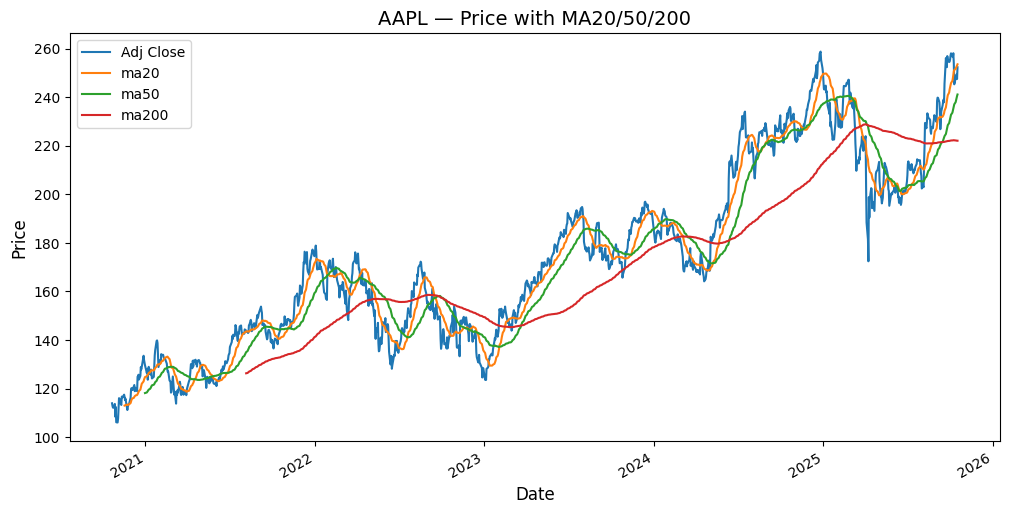

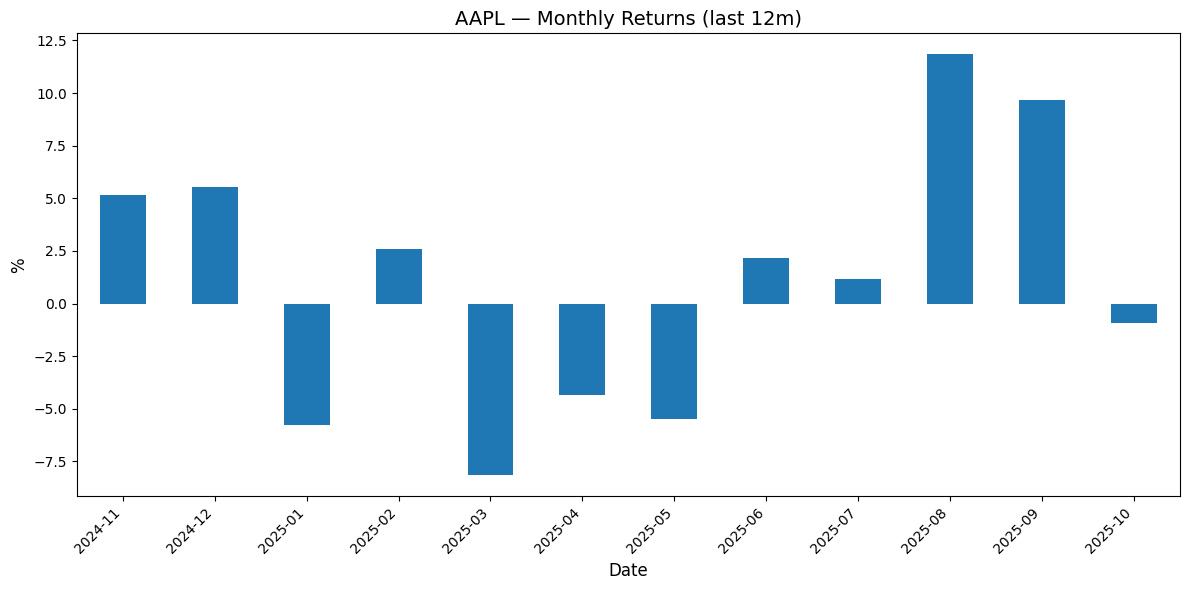

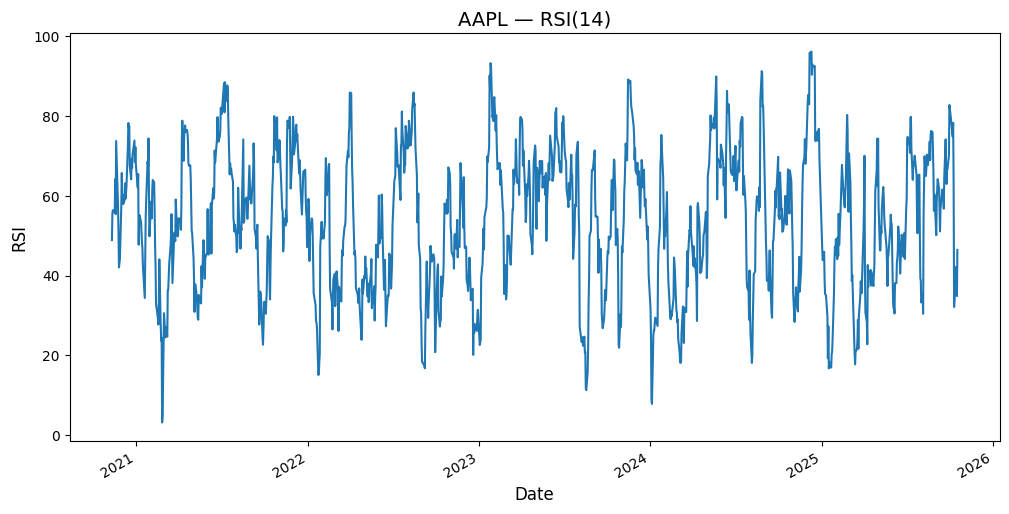

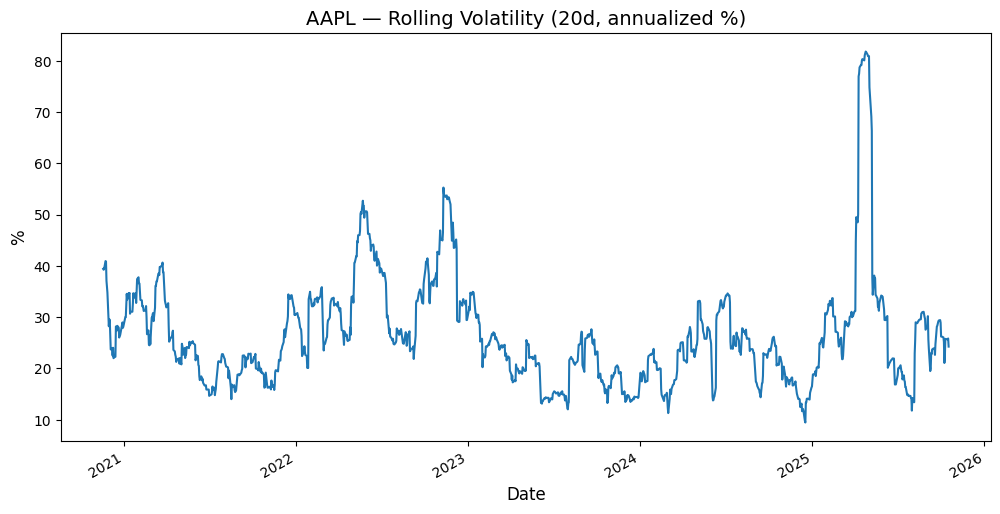

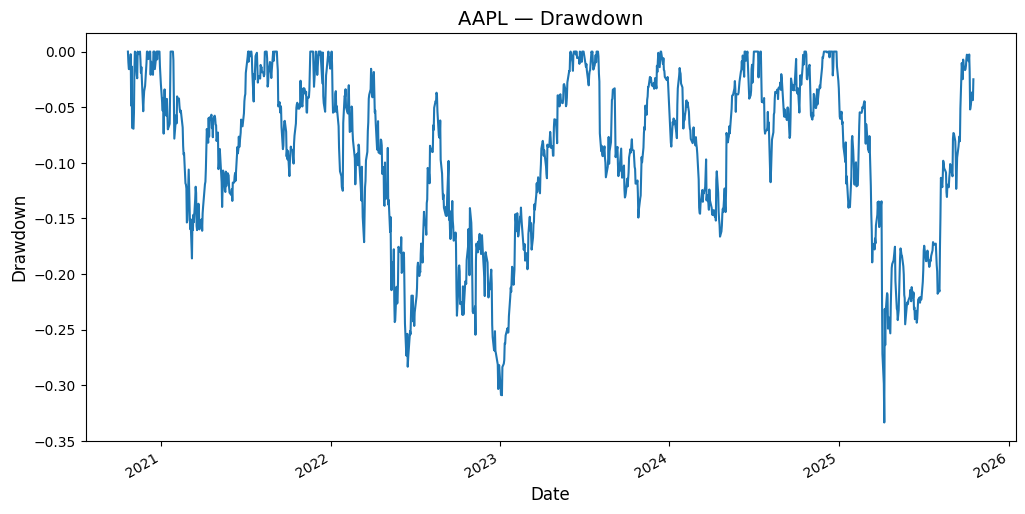

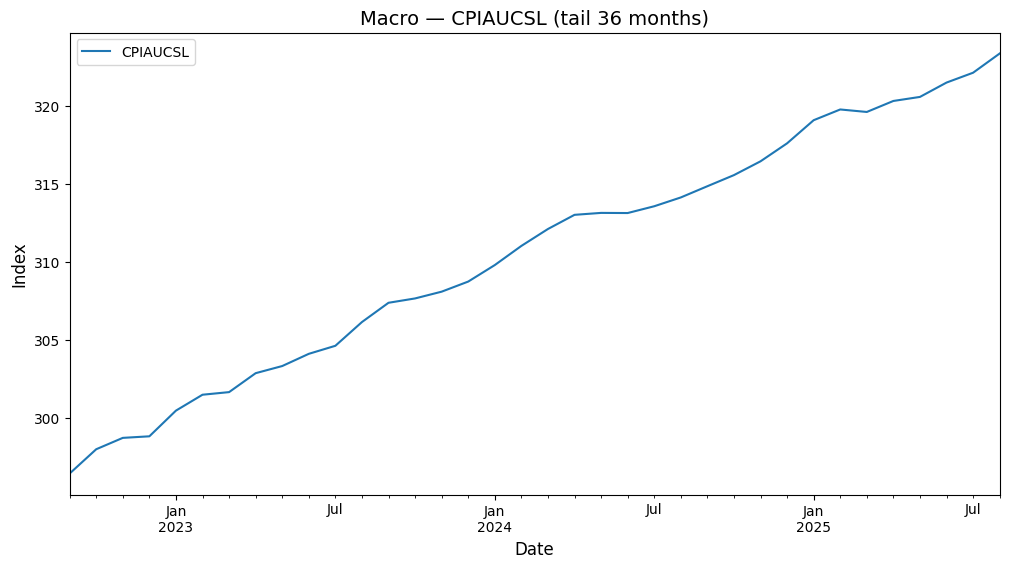

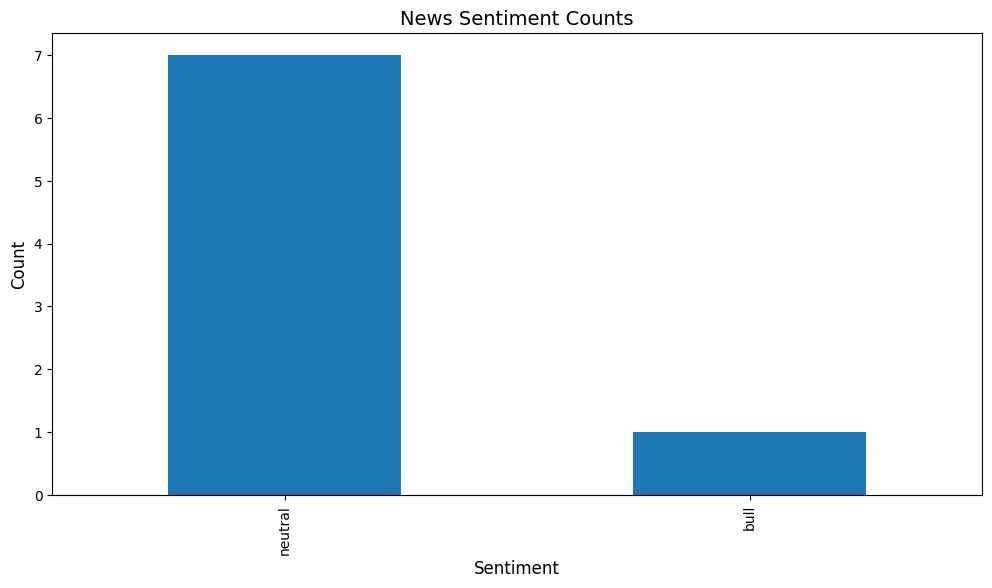

News after chaining + routing:
                                                                                                                                               title sentiment    route              route_reason            published              source
                                                                                 S&P 500 Earnings Surge: Magnificent 7 Lead As Recession Odds Plunge      bull earnings matched: earnings keyword 2025-10-19T11:00:00Z              Forbes
                                   Anker Japan、Anker史上最薄の厚さ約8.6mmでQi2ワイヤレス充電に対応したモバイルバッテリー「Anker Nano Power Bank (5000mAh, MagGo, Slim)」にホワイトモデルを追加。   neutral     news    fallback: general news 2025-10-19T05:10:58Z        Applech2.com
                                                             Big Tech's AI ambitions are remaking the US power grid. Consumers are paying the price.   neutral     news    fallback: general news 2025-10-18T16:05:35Z Yahoo Entertainment
                             

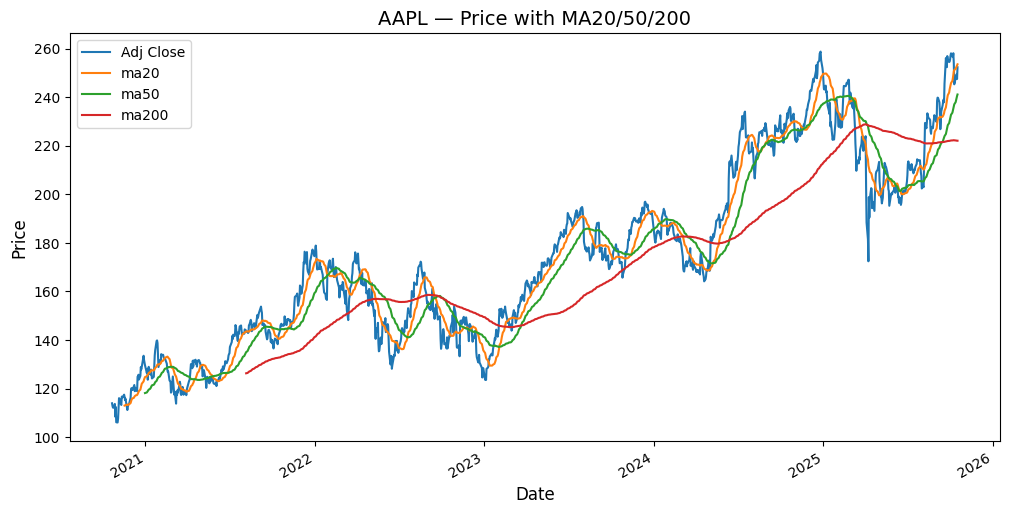

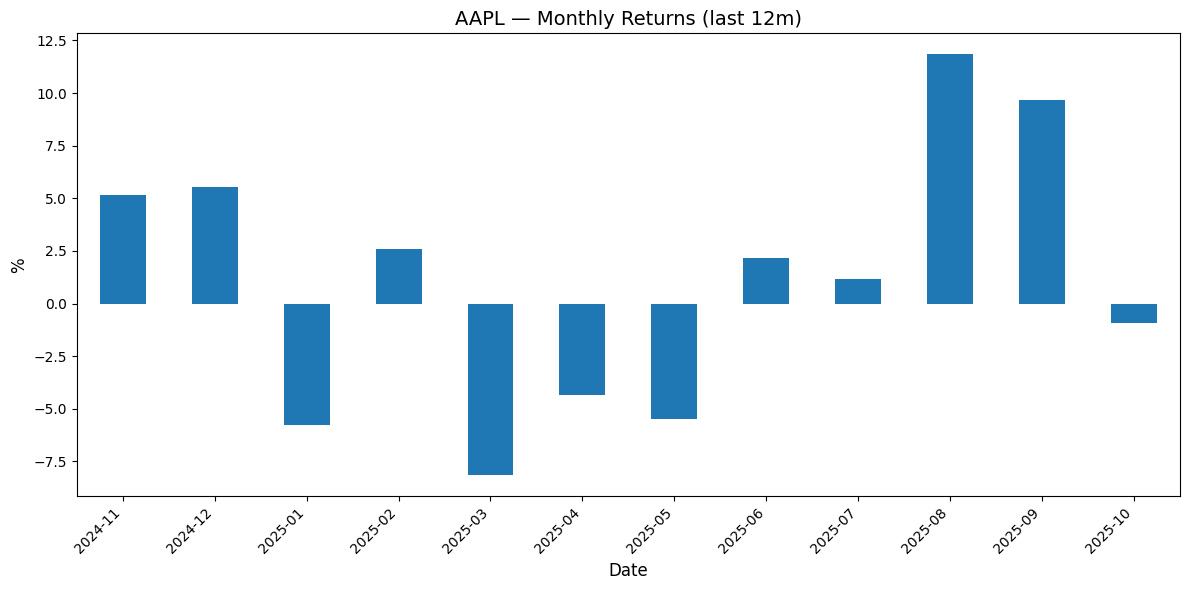

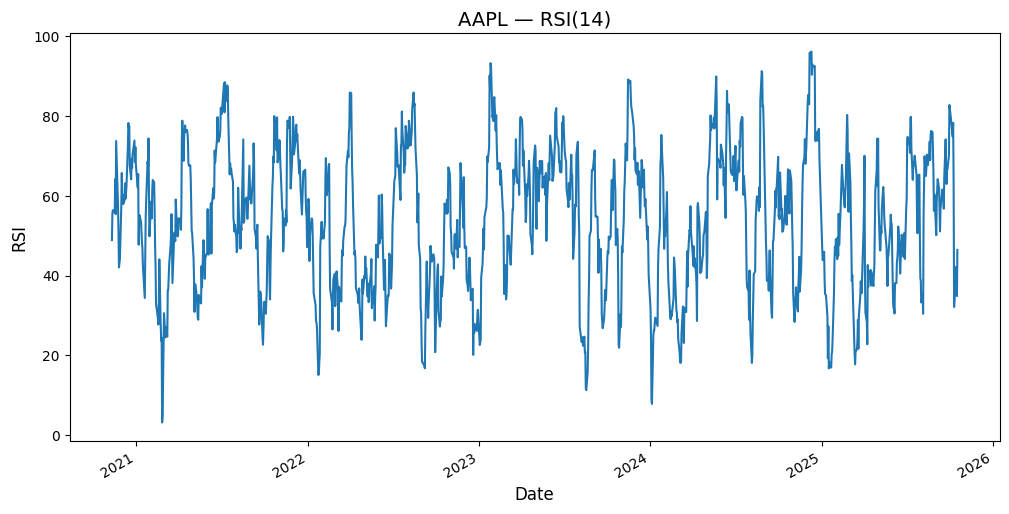

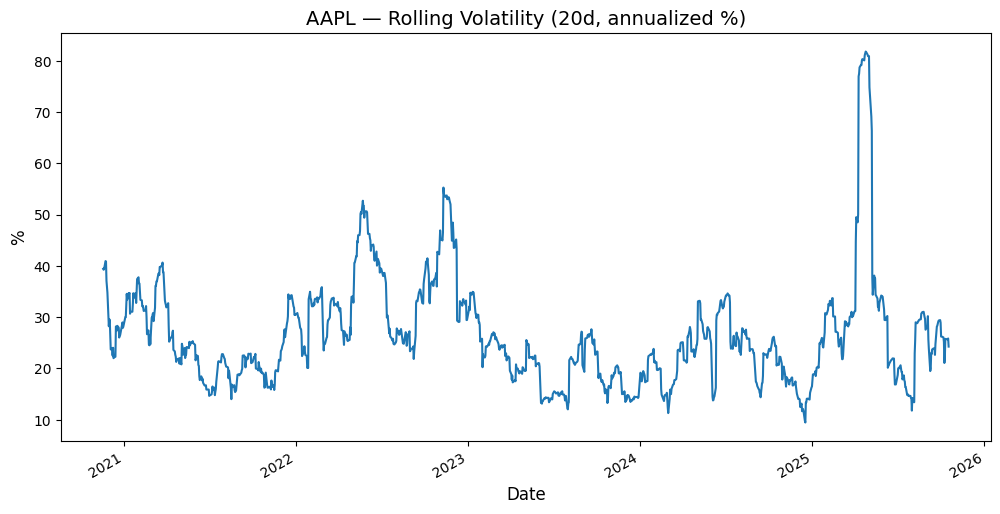

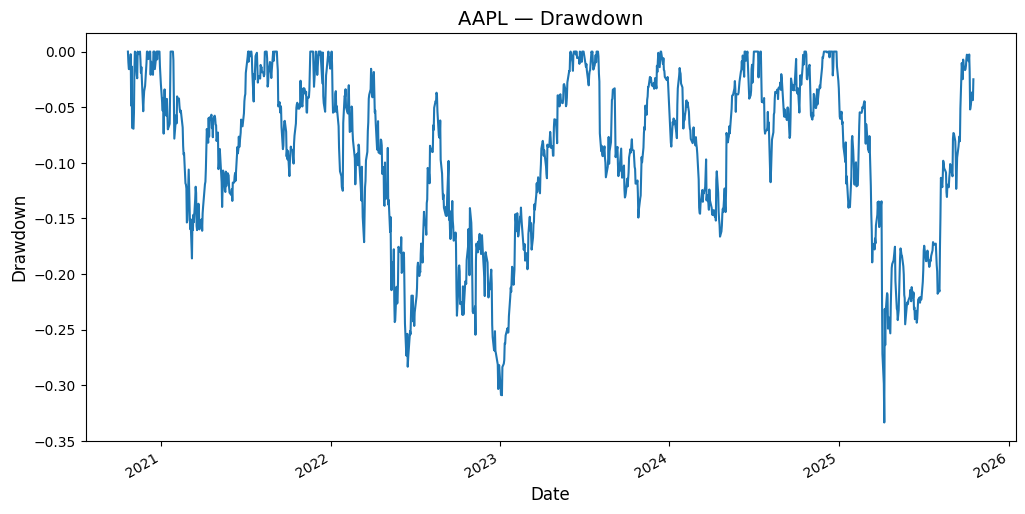

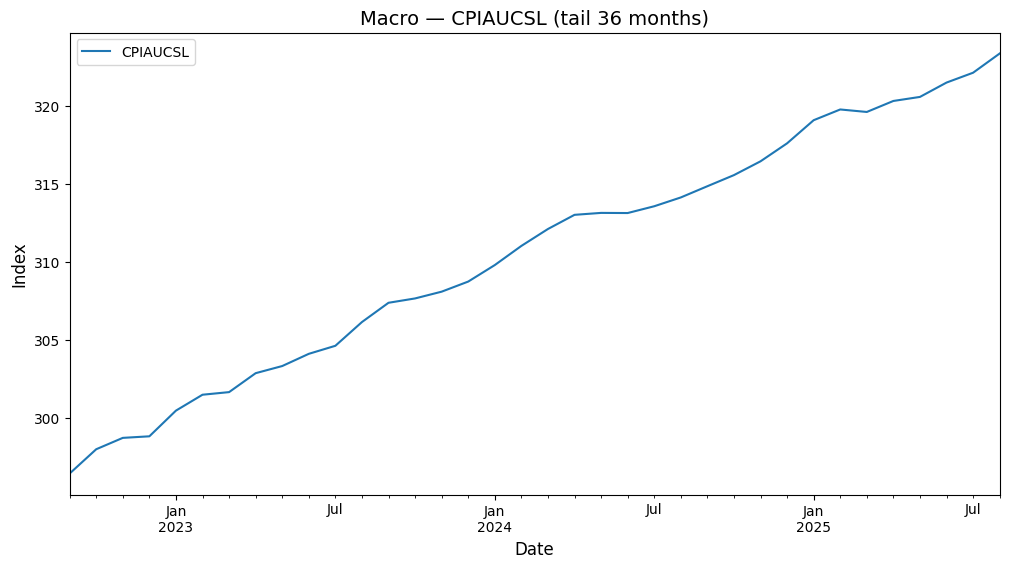

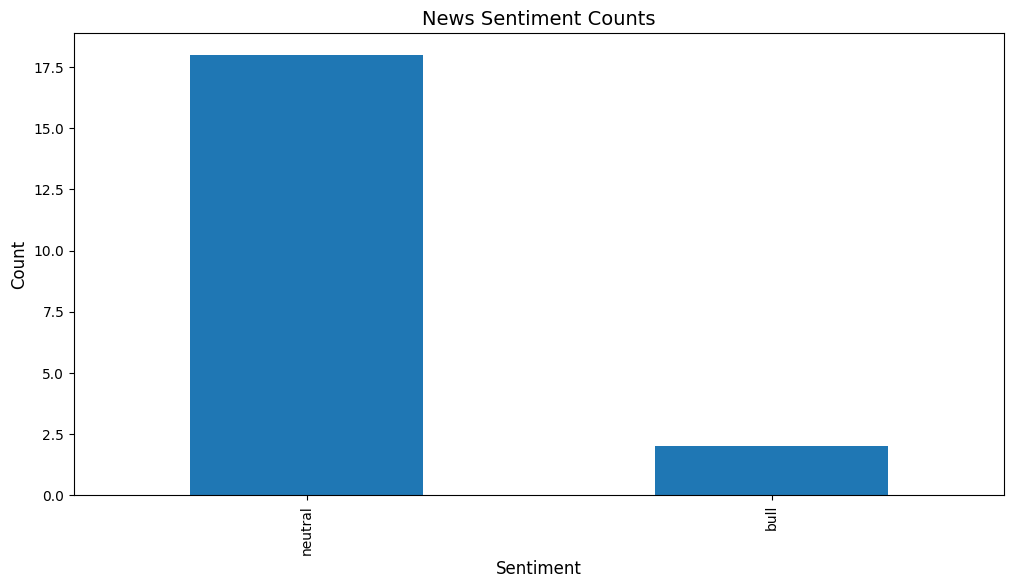

News after chaining + routing:
                                                                                                                                               title sentiment    route              route_reason            published              source
                                                                                 S&P 500 Earnings Surge: Magnificent 7 Lead As Recession Odds Plunge      bull earnings matched: earnings keyword 2025-10-19T11:00:00Z              Forbes
                                   Anker Japan、Anker史上最薄の厚さ約8.6mmでQi2ワイヤレス充電に対応したモバイルバッテリー「Anker Nano Power Bank (5000mAh, MagGo, Slim)」にホワイトモデルを追加。   neutral     news    fallback: general news 2025-10-19T05:10:58Z        Applech2.com
                                                             Big Tech's AI ambitions are remaking the US power grid. Consumers are paying the price.   neutral     news    fallback: general news 2025-10-18T16:05:35Z Yahoo Entertainment
                             

In [27]:
plan1 = build_plan_with_llm(ticker)
run1 = execute_plan(plan1, ticker)
render_visuals_save_memory(price_metrics_dataframe, macro_dataframe, news_dataframe, ticker)
feedback = derive_plan_feedback(run1)
plan2 = build_plan_with_llm(ticker, last_feedback=feedback)
print("\nRefined Plan: ", plan2)
run2 = execute_plan(plan2, ticker)
render_visuals_save_memory(price_metrics_dataframe, macro_dataframe, news_dataframe, ticker)

# Here is where the main pipeline calls are done. First a plan is built with an LLM, then it
# is executed, the visuals are rendered, the data is saved to memory and feedback is generated
# for the next run. Then when a second plan is done it is updated according to the feedback
# with an LLM. Then the previous steps are repeated to execute, show visuals and save data. This 
# in future can be organized in a loop with time stamps for when it should be run, e.g. every 5 
# hours to provide the latest info on the ticker of your choice.

Part 8 Results Summary:  
  
Data Source Overview:  
| Data Source | Provider | Records / Articles |
|--------------|-----------|--------------------|
| **Prices** | Stooq | 1,254 rows |
| **Financials** | Alpha Vantage | 4 rows |
| **Macro (CPI)** | FRED | 80 rows |
| **News** | NewsAPI | 8 articles |
  
All core data sources were successfully obtained. The pipeline integrated market data, financial fundamentals, macroeconomic indicators, and news sentiment to build comprehensive summaries and briefs.  
  
Iteration 1 – Initial Plan and Execution:  
The first plan was generated autonomously by the LLM based planner. It produced the following ordered steps:  
[{'step': 'fetch_prices', 'args': {'period': '1y', 'interval': '1d'}},   
{'step': 'fetch_financials'},   
{'step': 'fetch_macro', 'args': {'series_id': 'CPIAUCSL', 'start': '2019-01-01'}},   
{'step': 'fetch_news', 'args': {'n': 8}},   
{'step': 'summarize'},   
{'step': 'evaluate_and_improve'},   
{'step': 'visualize'},   
{'step': 'save_memory'}]  
  
This plan was executed successfully and generated complete outputs across all modules. The evaluation results showed strong coverage and evidence but moderate actionability (0) in both the rule based and LLM briefs. The feedback module, therefore, noted two main gaps:  
1. Low news sample size (8 articles).  
2. Absence of a specific “Action:” statement in the generated briefs.  
  
Iteration 2 – Refined Plan and Adaptation:  
Using the structured feedback, the LLM dynamically produced a refined plan. In this second plan, the news fetching step was explicitly adjusted to request more data (n = 20), and all other steps were retained in logical order:  
[{'step': 'fetch_prices', 'args': {'period': '1y', 'interval': '1d'}},  
{'step': 'fetch_financials', 'args': {}},  
{'step': 'fetch_macro', 'args': {'series_id': 'CPIAUCSL', 'start': '2019-01-01'}},  
{'step': 'fetch_news', 'args': {'n': 20}},  
{'step': 'summarize', 'args': {}},  
{'step': 'evaluate_and_improve', 'args': {}},  
{'step': 'visualize', 'args': {}},  
{'step': 'save_memory', 'args': {}}]    
  
This iteration resulted in wider news coverage and improved sentiment diversity. As expected, the v2 briefs incorporated explicit actions, improving their actionability scores from 0 → 1, and both rule based and LLM workflows achieved full critic totals (5/5).  
  
| Model Type | Version | Coverage | Evidence | Actionability | Factuality | Recency | Total | Comments |
|-------------|----------|-----------|-----------|----------------|-------------|----------|--------|-----------|
| **Rule Based** | v1 | 1 | 1 | 0 | 1 | 1 | **4** | Add a specific "Action:" |
| **Rule Based** | v2 | 1 | 1 | 1 | 1 | 1 | **5** | Improved |
| **LLM Based** | v1 | 1 | 1 | 0 | 1 | 1 | **4** | Add a specific "Action:" |
| **LLM Based** | v2 | 1 | 1 | 1 | 1 | 1 | **5** | Improved |
  
Both systems converged to optimal performance after the second run, demonstrating effective plan adaptation.  
  
Visual Summaries:  
Prices: Trend analysis using 20/50/200 day moving averages revealed a stable uptrend.  
Monthly Returns: Consistent gains across the last 12 months.  
RSI (14): Momentum neutral to mildly bullish.  
Volatility: 20 day rolling volatility remained steady.  
Drawdown: Contained drawdown recovery observed.  
Macro CPI: Continued rising inflation trend over the last three years.  
  
Memory and Persistence:  
| Timestamp (UTC) | Ticker | Insights | Next Step |
|------------------|---------|-----------|------------|
| 2025-10-20T13:12:47.612062Z | AAPL | Expanded metrics: MAs, RSI, vol, drawdown, Sharpe | Add peer comparison vs sector ETF |
| 2025-10-20T13:13:08.038435Z | AAPL | Expanded metrics: MAs, RSI, vol, drawdown, Sharpe | Add peer comparison vs sector ETF |
  
The system’s memory log recorded both iterations, preserving key analytical insights and planned follow-up actions for future adaptive runs.  
  
Agentic Loop Summary:  
The project’s execution flow demonstrated the full agentic AI cycle:  
1. Plan: The LLM autonomously built a sequence of steps for data retrieval and analysis.  
2. Act: The executor carried out the plan using live data sources and analytical tools.  
3. Reflect: The system derived structured feedback and quantitative scores.  
4. Replan: The LLM integrated this feedback into a refined plan (adding more data and improving the brief).  
5. Improve: The second run achieved better performance and completeness.  
  
This confirms the project’s architecture as a self-improving agentic system capable of learning from its own outputs to iteratively optimize results.  
  
Key Takeaways:  
* Two full LLM driven planning iterations were completed successfully.  
* The second plan explicitly increased data depth and improved brief quality.  
* Evaluation metrics verified measurable improvement between runs.  
* The memory system now preserves historical insights to inform future iterations.  
* The design fully operationalizes the plan, execute, evaluate, and adapt feedback loop foundational to agentic AI architectures.  